In [1]:
pip install lime

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
iris = load_iris()

In [5]:
df = pd.DataFrame(np.c_[iris['data'], iris['target']])

In [6]:
df.columns = ['sep_length', 'sep_width', 'pet_length', 'pet_width', 'target']

In [7]:
X = df.iloc[:,:4]
y = df['target']


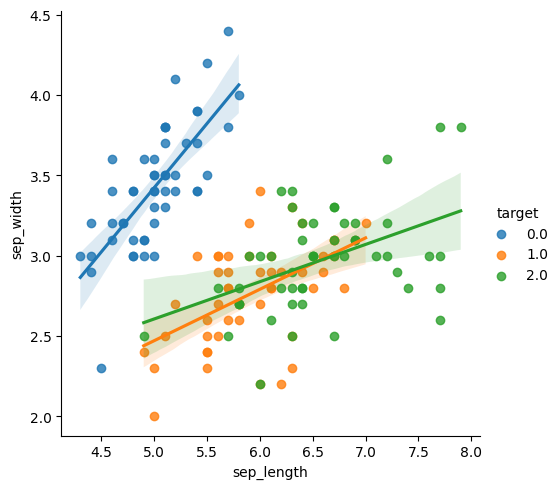

In [8]:
sns.lmplot(x='sep_length', y='sep_width', hue='target', data=df)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [10]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [11]:
from sklearn.metrics import accuracy_score
rf_pred = rf_model.predict(X_test)
print(accuracy_score(rf_pred,y_test))

lr_pred = lr_model.predict(X_test)
print(accuracy_score(lr_pred,y_test))

1.0
1.0


# Explaining the model

We can use built-in methods to explain model performance. The below uses the feature_importance_ attribute from the RF model, and coefficients from the logistic regression model. Note that the logistic regression is a binary model, so when we fit it on a multi-class problem, it actually constructs 3 models and therefore 3 sets of coefficients. Each model is Category vs. Everything Else - for example, the first model classifies observations as Category 0 or NOT Category 0. The next is Category 1 or NOT Category 1. You can see the difference in feature importance for each category, based on the coefficients.

In [12]:
rf_importance = rf_model.feature_importances_
print(rf_importance)

lr_importance = lr_model.coef_
print(lr_importance)

[0.11052961 0.02956651 0.44442316 0.41548072]
[[-0.50017868  0.83553833 -2.35079018 -0.95172929]
 [ 0.60124067 -0.22641809 -0.23140865 -0.8968191 ]
 [-0.10106199 -0.60912024  2.58219883  1.84854838]]


# SHAP and LIME explanations

In [13]:
import shap
import lime

/Users/sam/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
shap.initjs() # visualizations render in Jupyter

Now we compute the SHAP values. This function will compute values for each observation (in your train or test dataset). There will be SHAP values for each feature, and each class. So since we have a dataset with 4 features and 3 output classes, for each observation we will get a 4x3 matrix (4 rows and 3 columns)

In [15]:
explainer_rf = shap.Explainer(rf_model)

In [16]:
# computing the SHAP values
# use the TEST data to explain how the model is making predictions
shap_values_rf_test = explainer_rf.shap_values(X_test)

In [17]:
# let's have a look at the 2nd observation. First let's print the X_test values
X_test.iloc[1]

sep_length    5.8
sep_width     2.7
pet_length    4.1
pet_width     1.0
Name: 67, dtype: float64

In [18]:
# now let's print the predicted probabilities for this observation
pred = rf_model.predict_proba(X_test)
pred[1]

array([0., 1., 0.])

In [19]:
# we can see that the predicted probabilities are as follows: class 0 = 0%, class 1 = 98%, class 2 = 2%
# therefore, this observation would be classified as Class 1

In [20]:
# now let's produce the shap values which explain how each feature contributes to the predicted probabilities above
# the array represents the shap values for each class
# the rows are each feature (sep length, sep width, pet length, and pet width)
# the columns are each class

shap_values_rf_test[1]

array([[-0.02765985,  0.04587053, -0.01821068],
       [-0.00656849,  0.0079382 , -0.00136971],
       [-0.14375744,  0.32087762, -0.17712018],
       [-0.14726421,  0.30031365, -0.15304944]])

In [21]:
# isolating just the first column from above, this tells us each feature's contribution
# to the prediction of whether or not the 2nd observation in the dataset is predicted to be class 0
# I have transposed the values
shap_values_rf_test[1].T[0]


array([-0.02765985, -0.00656849, -0.14375744, -0.14726421])

In [22]:
# now we can create an explanation object for the observation
shap_explanation_class0 = shap.Explanation(values=shap_values_rf_test[1].T[0], # isolating the second observation (position 1), transposing, and selecting the first category (position 0)
                                    base_values=explainer_rf.expected_value[0], # calculate the expected value for the first category (position 0)
                                    data=X_test.iloc[1,:], # isolate the data behind the second observation (position 1)
                                    feature_names=X_test.columns) # column names

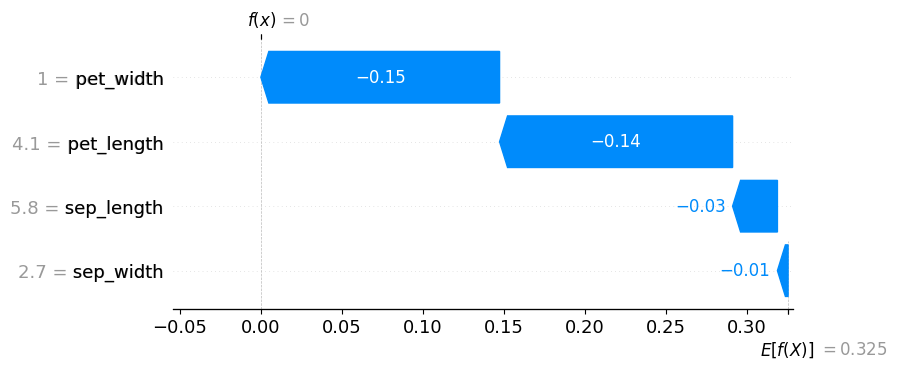

In [23]:
# now we can plot the explanation in a waterfall
shap.plots.waterfall(shap_explanation_class0)


In the left hand side, we see each of the input variables for the observation and their values. On the top left where we see f(x) = 0, this is the final prediction of whether this observation falls in class 0. If you recall, from the predict_proba() function, the predicted probability of this observation falling in Class 0 is 0% . We can see that Petal Length, and Petal Width had the biggest contribution to this prediction.

The baseline prediction is 0.354 - we can pull this using the expected_value function. This is computed by SHAP, and represents the average log-odds over the ensemble of trees (in the RF model). We can then add up the SHAP values of each feature to the expected value to arrive at the predicted probability.

In our case, this is: 0.354 - 0 - 0.04 - 0.16 - 0.16 = -0.006

Let's try the same observation, but understanding Class = 1. This one has a 98% probability (therefore the observation would be classified as this category).


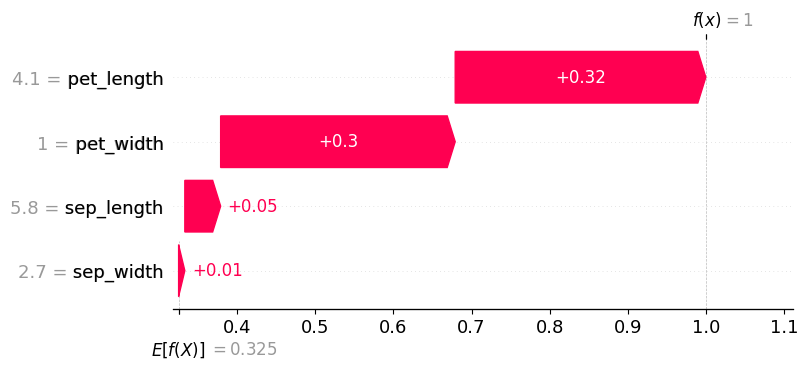

In [24]:
# now we can create an explanation object for the observation
shap_explanation_class1 = shap.Explanation(values=shap_values_rf_test[1].T[1], 
                                    base_values=explainer_rf.expected_value[1], 
                                    data=X_test.iloc[1,:], 
                                    feature_names=X_test.columns)

shap.plots.waterfall(shap_explanation_class1)

In [25]:
X_test.head()

,sep_length,sep_width,pet_length,pet_width
16,5.4,3.9,1.3,0.4
67,5.8,2.7,4.1,1.0
122,7.7,2.8,6.7,2.0
114,5.8,2.8,5.1,2.4
59,5.2,2.7,3.9,1.4


In [26]:
# plot summary for full model
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_test[..., 1], X_test)


The above is a force plot which explains the model overall. Here the observations are NOT ordered according to the X_test order, but rather based on similarity. So in the beginning we have groups of observations positively influenced by pet_width and pet_length, and then we have observations negatively influenced by these values. On the X-axis, we see every observation in our dataset. The y-axis represents the mod output in log-odds. The bands show you the size of contribution from each feature, and if you hover over them you can see the values of the features for each of the observations. Positive contributions (red sections) mean that the features increase the likelihood of an observation falling in the given class. Negative (blue sections) mean that the features contribute negatively, and it's likely those observations don't fall in the selected class. 

We can try below for the 3rd class. We'll see a change in patterns for this class.

In [27]:
shap.force_plot(explainer_rf.expected_value[2], shap_values_rf_test[..., 2], X_test)


Now to repeat the process for the Logistic Regression model. We need to use a different explainer LinearExplainer, and we require a masker parameter. Note: you can use KernelExplainer as well, which is model agnostic. 

Check the SHAP documentation for types of explainers you can use, either model-specific or model agnostic. https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html#Logistic-regression

In [28]:
explainer_lr = shap.LinearExplainer(lr_model, masker = shap.maskers.Independent(X_train))

In [29]:
explainer_lr = shap.KernelExplainer(lr_model.predict_proba, X_train)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [30]:
shap_values = explainer_lr.shap_values(X_test)


100%|██████████| 30/30 [00:00<00:00, 147.93it/s]


In [31]:
# Plot summary for SHAP values for entire Logistic Regression model
shap.force_plot(explainer_lr.expected_value[0], shap_values[..., 0], X_test)


We can also use a Summary Plot. Here we see the shap values for each feature as they contribute to the 1st class predictions.

The Y-axis lists the features in order of importance. The X-axis shows the shap values. Positive values push the prediction towards high probability of falling into the class, negative values push the prediction away from the class. The colors show the feature value. The clusters show where the points are. 

For example: for pet_length, low values (blue) tend to push the prediction higher (i.e., make it more likely that the observation is in class 0), while high values push the prediction lower (i.e., make it less likely the observation is in class 0). The horizontal spread of each cluster represents the different SHAP values for each point. The vertical spread doesn't mean anything, it's just a visual representation of the dots so you can see them clearly. 

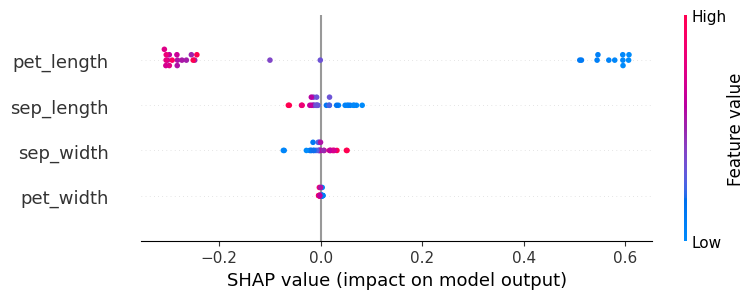

In [32]:
shap.summary_plot(shap_values[...,0], X_test)

#### Example of Using LIME

We can use LIME for individual observations. This will again show us the probability of an output, and how each fature contributes to that probability and what the decision criteria is.

In [33]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_array, feature_names = df.columns)

NameError: name 'X_array' is not defined

In [87]:
exp = explainer.explain_instance(X_array[0], rfm.predict_proba, num_features=4)
exp.show_in_notebook()